In [1]:
import os
import sys
import torch
import cv2
import pandas as pd
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image, ImageDraw
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
fname = "icml_face_data.csv"
df = pd.read_csv(fname)
print(len(df))

35887


In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'} # 使用する感情の数

In [6]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 1, 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i,row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
    return image_array, image_label

In [7]:
#train_image_array, train_image_label = prepare_data(df[df[' Usage']=='Training'])
#val_image_array, val_image_label = prepare_data(df[df[' Usage']=='PrivateTest'])
#test_image_array, test_image_label = prepare_data(df[df[' Usage']=='PublicTest'])

In [8]:
train_image_array_tmp, train_image_label_tmp = prepare_data(df[df[' Usage']=='Training'])
val_image_array_tmp, val_image_label_tmp = prepare_data(df[df[' Usage']=='PrivateTest'])
test_image_array_tmp, test_image_label_tmp = prepare_data(df[df[' Usage']=='PublicTest'])
train_image_array = []
train_image_label = []
val_image_array = []
val_image_label = []
test_image_array = []
test_image_label = []
for (d1, d2) in zip(train_image_array_tmp, train_image_label_tmp):
  train_image_array.append(d1)
  train_image_label.append(d2)
for (d1, d2) in zip(val_image_array_tmp, val_image_label_tmp):
  val_image_array.append(d1)
  val_image_label.append(d2)
for (d1, d2) in zip(test_image_array_tmp, test_image_label_tmp):
  test_image_array.append(d1)
  test_image_label.append(d2)

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
           rotation_range=0,
           width_shift_range=0,
           height_shift_range=0,
           shear_range=0,
           zoom_range=0,
           horizontal_flip=True,
           vertical_flip=False)

d = datagen.flow(train_image_array_tmp, batch_size=1, shuffle=False)
# print(len(train_image_array))
# print(len(d))
# print(len(d[0]))
# print(len(d[0][0]))
# print(len(d[0][0][0]))
# print(len(d[0][0][0][0]))
# print(len(train_image_array))
# print(len(train_image_array[0]))
# print(len(train_image_array[0][0]))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [10]:
# print(len(train_image_array))
# train_image_array.append(d[0][0])
# print(len(train_image_array))
for i in range(len(d)):
  train_image_array.append(d[i][0])
  label = train_image_label[i]
  train_image_label.append(label)
print(len(train_image_array))
print(len(train_image_label))

57418
57418


In [ ]:
""" datagen = ImageDataGenerator(
           rotation_range=0,
           width_shift_range=0,
           height_shift_range=0,
           shear_range=0,
           zoom_range=0,
           horizontal_flip=False,
           vertical_flip=True,
           )

d = datagen.flow(train_image_array_tmp, batch_size=1, shuffle=False)
print(len(d)) """

28709


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
""" for i in range(len(d)):
  train_image_array.append(d[i][0])
  label = train_image_label[i]
  train_image_label.append(label)
print(len(train_image_array))
print(len(train_image_label)) """

0


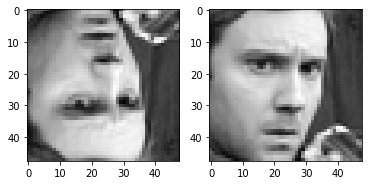

In [ ]:
#data = imgs[0]
data = d[0][0][0]
#data = train_image_array[28712][0]
plt.subplot(1, 2, 1), plt.imshow(np.uint8(data))
plt.gray()
data = train_image_array[0][0]
plt.subplot(1, 2, 2), plt.imshow(data)
print(test_image_label[0])

In [11]:
def train2batch(data, category, batch_size=32):
    data_batch = []
    cat_batch = []
    data, category = shuffle(data, category)
    for i in range(0, len(data), batch_size):
        data_batch.append(data[i:i+batch_size])
        cat_batch.append(category[i:i+batch_size])
    return data_batch, cat_batch

In [12]:
# データの作成
train_data, train_label = train2batch(train_image_array, train_image_label)
val_data, val_label = train2batch(val_image_array, val_image_label)
test_data, test_label = train2batch(test_image_array, test_image_label)
#train_data = list(map(lambda x: x / 255.0, train_data))

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 32, 5)
        self.fc1 = nn.Linear(32 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        #x = x.view(-1, 32*9*9)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        return x

In [14]:
def evaluate(data, label):
    epoch_test_l = 0
    epoch_test_a = 0
    with torch.no_grad():
        for i in range(len(data)):
            inputs = torch.tensor(data[i]).to(device, dtype=torch.float)
            #inputs = inputs.unsqueeze(1)
            labels = torch.tensor(label[i]).to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_l += loss.item() / inputs.shape[0]
            test_acc = (outputs.argmax(dim=1) == labels).float().mean()
            epoch_test_a += test_acc / inputs.shape[0]
    return epoch_test_l, epoch_test_a

In [15]:
def evaluate_value(data, label):
    epoch_test_l = 0
    epoch_test_a = 0
    ans = 0
    cnt = 0
    with torch.no_grad():
        for i in range(len(data)):
            inputs = torch.tensor(data[i]).to(device, dtype=torch.float)
            #inputs = inputs.unsqueeze(1)
            labels = torch.tensor(label[i]).to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_l += loss.item() / inputs.shape[0]
            cnt += inputs.shape[0]
            test_acc = (outputs.argmax(dim=1) == labels).float().mean()
            #print(outputs.argmax(dim=1))
            #print(labels)
            #print((outputs.argmax(dim=1) == labels).sum())
            ans += (outputs.argmax(dim=1) == labels).sum()
            epoch_test_a += test_acc / inputs.shape[0]
    return epoch_test_l, epoch_test_a, ans, cnt

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device : ", device)
model = CNN().to(device)
#print(model)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)
#model_path = "model_expand.pth"
model_path = "model_expand.pth"

device :  cuda:0


In [ ]:
epochs = 20
train_loss = []
test_loss = []
min_loss = 100.0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_test_loss = 0
    epoch_test_acc = 0

    model.train()
    for i in range(len(train_data)):
        inputs = torch.tensor(train_data[i], requires_grad=True).to(device, dtype=torch.float)
        #inputs = inputs.unsqueeze(1)
        labels = torch.tensor(train_label[i]).to(device, dtype=torch.long)
        #labels = torch.from_numpy(train_label[i]).to(device).clone()
        #print(labels)
        #print('inputs :', inputs.shape)
        #print('lables :', labels.shape)
        #print(inputs.shape[0])
        #print(inputs[0][0])

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print(loss)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() / inputs.shape[0]
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_train_acc += acc / inputs.shape[0]
        #print("acc :", acc, "epoch_train_acc :", epoch_train_acc)
    #if(epoch + 1) % 10 == 0:
    epoch_test_loss, epoch_test_acc = evaluate(val_data, val_label)
    print(f'Epoch {epoch+1} : train acc. {epoch_train_acc:.2f} train loss {epoch_train_loss:.2f}')
    print(f'Epoch {epoch+1} : test acc. {epoch_test_acc:.2f} test loss {epoch_test_loss:.2f}')
    if min_loss > epoch_test_loss:
      min_loss = epoch_test_loss
      torch.save(model.state_dict(), model_path)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

Epoch 1 : train acc. 17.10 train loss 97.79
Epoch 1 : test acc. 1.44 test loss 5.94
Epoch 2 : train acc. 21.08 train loss 90.31
Epoch 2 : test acc. 1.57 test loss 5.61
Epoch 3 : train acc. 23.17 train loss 85.51
Epoch 3 : test acc. 1.63 test loss 5.42
Epoch 4 : train acc. 24.80 train loss 81.77
Epoch 4 : test acc. 1.68 test loss 5.30
Epoch 5 : train acc. 26.21 train loss 78.53
Epoch 5 : test acc. 1.68 test loss 5.20
Epoch 6 : train acc. 27.54 train loss 75.50
Epoch 6 : test acc. 1.68 test loss 5.16
Epoch 7 : train acc. 28.80 train loss 72.50
Epoch 7 : test acc. 1.68 test loss 5.12
Epoch 8 : train acc. 30.09 train loss 69.47
Epoch 8 : test acc. 1.70 test loss 5.11
Epoch 9 : train acc. 31.45 train loss 66.37
Epoch 9 : test acc. 1.72 test loss 5.13
Epoch 10 : train acc. 32.83 train loss 63.10
Epoch 10 : test acc. 1.73 test loss 5.18
Epoch 11 : train acc. 34.33 train loss 59.79
Epoch 11 : test acc. 1.74 test loss 5.25
Epoch 12 : train acc. 35.79 train loss 56.33
Epoch 12 : test acc. 1.74 t

In [17]:
model.load_state_dict(torch.load(model_path))
epoch_test_loss, epoch_test_acc, ans, cnt = evaluate_value(test_data, test_label)
print(f'test acc. {epoch_test_acc:.2f} test loss {epoch_test_loss:.2f}')
print("正解率 :", ans / cnt)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


test acc. 1.72 test loss 5.33
正解率 : tensor(0.4698, device='cuda:0')


In [ ]:
print(train_loss)
print(test_loss)

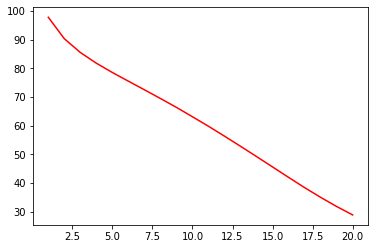

In [ ]:
x = np.array(list(range(1, epochs+1)))
plt.figure()
plt.plot(x, train_loss, color="red")
#plt.plot(x, test_loss, color="blue")

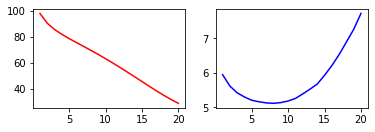

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
x = np.array(list(range(1, epochs+1)))
ax1.plot(x, train_loss, color="red", label="学習")
ax2.plot(x, test_loss, color="blue", label="テスト")

In [ ]:
print(len(test_data[0]))
print(len(test_data[0][0]))
print(len(test_data[0][0][0]))

32
1
48


In [25]:
class pycolor:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    PURPLE = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    RETURN = '\033[07m' #反転
    ACCENT = '\033[01m' #強調
    FLASH = '\033[05m' #点滅
    RED_FLASH = '\033[05;41m' #赤背景+点滅
    END = '\033[0m'


In [26]:
def sigmoid(a):
  return 1 / (1 + np.exp(-a))

def softmax(a):
  #print(np.sum(np.exp(a)))
  return np.exp(a) / np.sum(np.exp(a))

In [47]:
def result(id):
  with torch.no_grad():
    input = torch.tensor(test_image_array[id]).to(device, dtype=torch.float)
    input = input.unsqueeze(0)
    outputs = model(input)
    ans = outputs.argmax(dim=1).item()
    if ans == test_image_label[id]:
      print(pycolor.RED+"Success"+pycolor.END)
    else:
      print(pycolor.RED+"Failed :"+pycolor.END, pycolor.RED+emotions[test_image_label[id]]+pycolor.END)
    #print(ans, test_image_label[id])
    x = outputs.to('cpu').detach().numpy().copy()
    sum = softmax(x)
    index_tmp = np.argpartition(sum, -4)[-4:]
    index = []
    for i in range(len(index_tmp[0])):
      index.insert(0, index_tmp[0][i])
    #print(sum)
    #print(index)
  if sum[0][index[0]] > 0.7:
    print(pycolor.RED+"Very"+pycolor.END, pycolor.RED+emotions[index[i]]+pycolor.END)
  elif sum[0][index[0]] > 0.5:
    print(pycolor.RED+emotions[index[0]]+pycolor.END)
  else:
    print(pycolor.RED+"A little"+pycolor.END, pycolor.RED+emotions[index[0]]+pycolor.END)
  for i in range(4):
    print(emotions[index[i]], ":", sum[0][index[i]])
  #print(sum)
  data = test_image_array[id][0]
  plt.subplot(1, 2, 1), plt.imshow(np.uint8(data))


Failed : Sad
Angry
Angry : 0.6136883
Fear : 0.16525497
Neutral : 0.10425284
Sad : 0.07654041


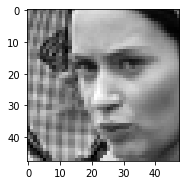

In [61]:
result(13)